In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


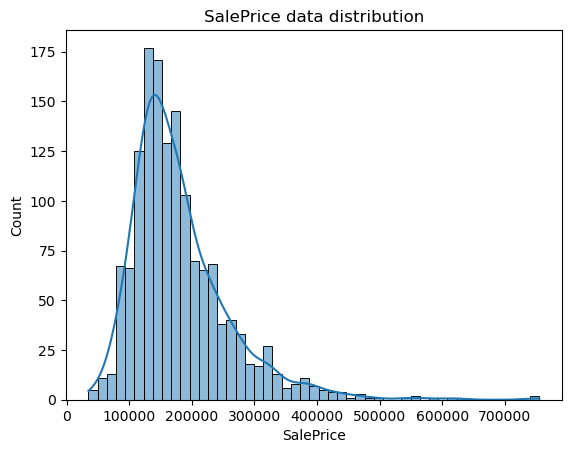

In [4]:
sns.histplot(x=train['SalePrice'], kde=True)
plt.title('SalePrice data distribution')
plt.show()

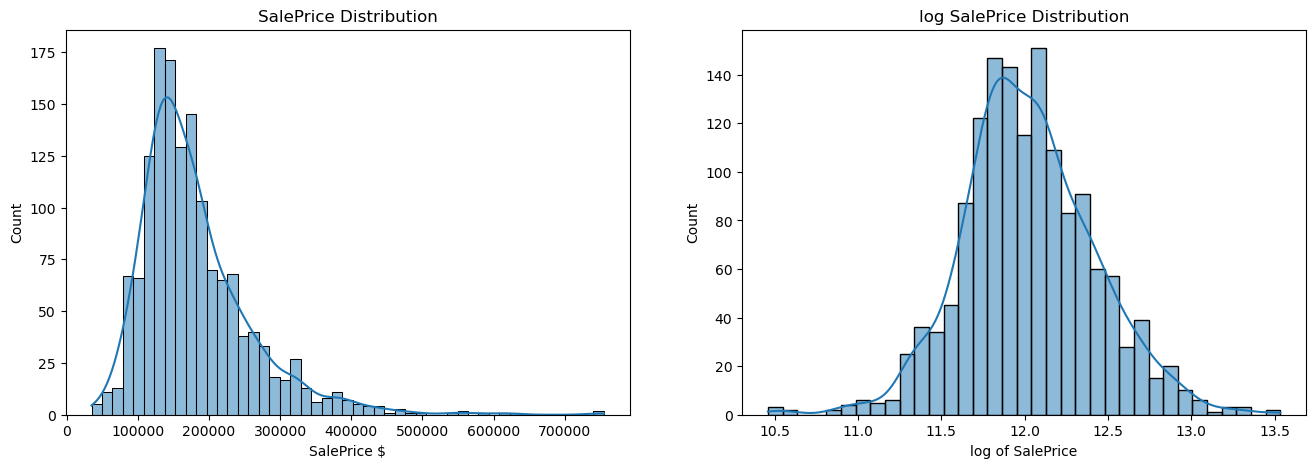

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
sns.histplot(x=train['SalePrice'], kde=True, ax=ax[0])
sns.histplot(x=np.log1p(train['SalePrice']), kde=True, ax=ax[1])
ax[0].set(title='SalePrice Distribution', xlabel='SalePrice $')
ax[1].set(title='log SalePrice Distribution', xlabel='log of SalePrice')
plt.show()

In [6]:
X = train.drop(columns=['SalePrice', 'Id'], axis=1)
X_test = test.drop(columns=['Id'], axis=1)
y = np.log1p(train['SalePrice'])

## Pipeline for data imputation and onehotencoding and normalization

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

In [8]:
def get_preprocessor(train_df, test_df=None):
    # pipeline for numeric column 
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
    )
    
    # pipeline for categorical column
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
#         OneHotEncoder(drop='if_binary', handle_unknown='ignore')
#         LabelEncoder()
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

    )
    
    # Separate numerical and categorical column
    numeric_columns = train_df.select_dtypes(exclude='object').columns
    categorical_columns = train_df.select_dtypes(include='object').columns
    
    # combine pipeline using columntransformer
    preprocessor = ColumnTransformer(
        transformers= [
            ('num', numeric_transformer, numeric_columns),
            ('cat', categorical_transformer, categorical_columns)
        ]
    )
    
    # Fit the preprocessor on the training data
    preprocessor.fit(train_df)
    
    # Transform the training data
    train_transformed = preprocessor.transform(train_df)
    
    # Convert sparse matrix to dense format if necessary
    if hasattr(train_transformed, "toarray"):
        train_transformed = train_transformed.toarray()
    
    # Get the features names
    feature_names = preprocessor.get_feature_names_out()
    
    # Convert to DataFrame
    preprocessed_train = pd.DataFrame(train_transformed, columns=feature_names)
    
    # If test data is provided, transform it using the fitted preprocessor
    if test_df is not None:
        test_transformed = preprocessor.transform(test_df)
        if hasattr(test_transformed, "toarray"):
            test_transformed = test_transformed.toarray()
        preprocessed_test = pd.DataFrame(test_transformed, columns=feature_names)
        return preprocessed_train, preprocessed_test
    
    return preprocessed_train



In [9]:
X_prep, test_prep = get_preprocessor(X, X_test)

In [10]:
X_prep

,num__MSSubClass,num__LotFrontage,num__LotArea,num__OverallQual,num__OverallCond,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,...,cat__GarageType,cat__GarageFinish,cat__GarageQual,cat__GarageCond,cat__PavedDrive,cat__PoolQC,cat__Fence,cat__MiscFeature,cat__SaleType,cat__SaleCondition
0,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
1,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
2,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
3,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,...,5.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,0.0
4,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.073375,-0.357114,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.570750,-0.973018,-0.288653,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
1456,-0.872563,0.687385,0.266407,-0.071836,0.381743,0.222975,0.151865,0.087911,0.759659,0.722112,...,1.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
1457,0.309859,-0.175462,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.570750,-0.369871,-0.288653,...,1.0,1.0,4.0,4.0,2.0,2.0,0.0,2.0,8.0,4.0
1458,-0.872563,-0.084636,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.570750,-0.865548,6.092188,...,1.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0


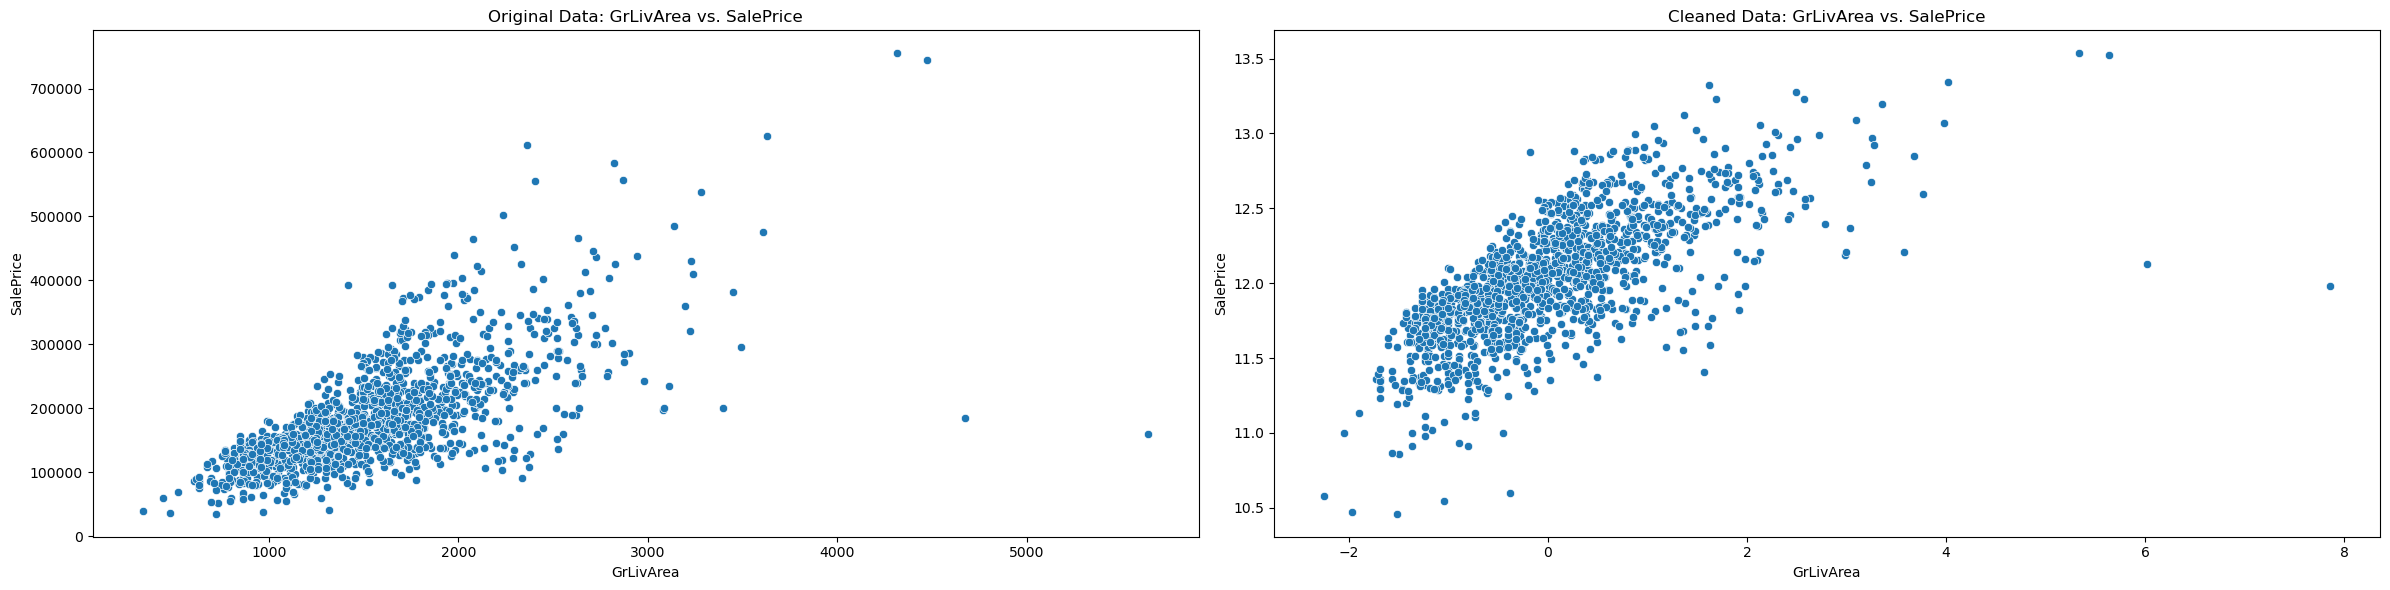

In [11]:
# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Original Data
sns.scatterplot(ax=axes[0], x=train['GrLivArea'], y=train['SalePrice'])
axes[0].set_title('Original Data: GrLivArea vs. SalePrice')
axes[0].set_xlabel('GrLivArea')
axes[0].set_ylabel('SalePrice')

# Cleaned Data
sns.scatterplot(ax=axes[1], x=X_prep['num__GrLivArea'], y=y)
axes[1].set_title('Cleaned Data: GrLivArea vs. SalePrice')
axes[1].set_xlabel('GrLivArea')
axes[1].set_ylabel('SalePrice')

# Show plots
plt.tight_layout()
plt.show()

In [12]:
X_prep['num__GrLivArea'].max()

7.855574356961303

In [13]:
# removing 4 value as outliers from above data that standout from other
indices_to_remove = X_prep[X_prep['num__GrLivArea'] > 5].index

X_prep = X_prep.drop(indices_to_remove)
y = y.drop(indices_to_remove)

In [14]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_prep, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [16]:
gbr = GradientBoostingRegressor()

In [17]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0]
}


In [18]:
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

In [19]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time= 

[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=3, min_samples_split=2, n_estimators=200, subsample=0.9; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=4, min_samples_le

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.9; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.9; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.9; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_lea

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.9; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=

[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=5, min_samples_le

[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=200, subsample=0.9; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf

[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=200, subsample=0.9; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.9; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf

[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_l

[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_l

[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_l

[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_l

[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.9; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=50, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [20]:
best_params = grid_search.best_params_
print(best_params)

{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200, 'subsample': 0.9}


In [37]:
gbr_best = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=600,
    subsample=0.9
)

In [38]:
gbr_best.fit(X_train, y_train)

GradientBoostingRegressor(min_samples_split=3, n_estimators=600, subsample=0.9)

In [39]:
# 3. Make predictions
y_train_pred = gbr_best.predict(X_train)
y_val_pred = gbr_best.predict(X_val)

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [41]:
# 4. Evaluate the performance
mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)

In [42]:
print(f'MSE: {mse_val}')
print(f'MAE: {mae_val}')
print(f'r2: {r2_val}')

MSE: 0.016703155799417592
MAE: 0.08829949194347736
r2: 0.8942426411767546


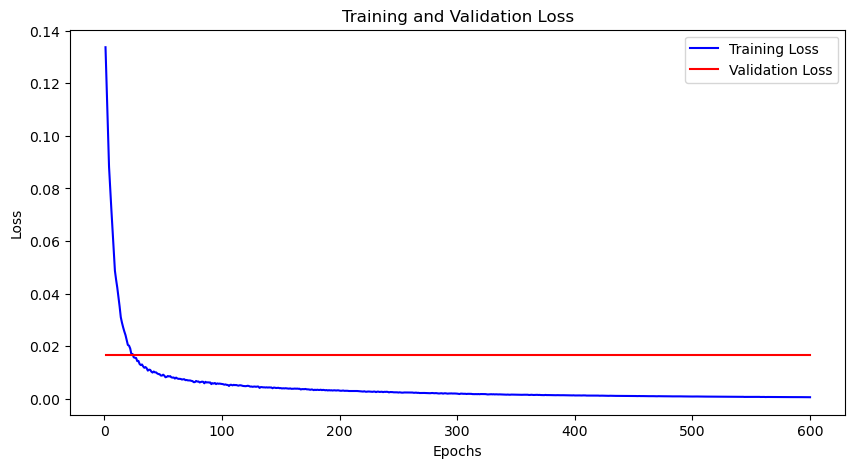

In [43]:
# 5. Plot Training and Test Loss
epochs = range(1, len(gbr_best.train_score_) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, gbr_best.train_score_, 'b-', label='Training Loss')
plt.plot(epochs, [mse_val]*len(epochs), 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

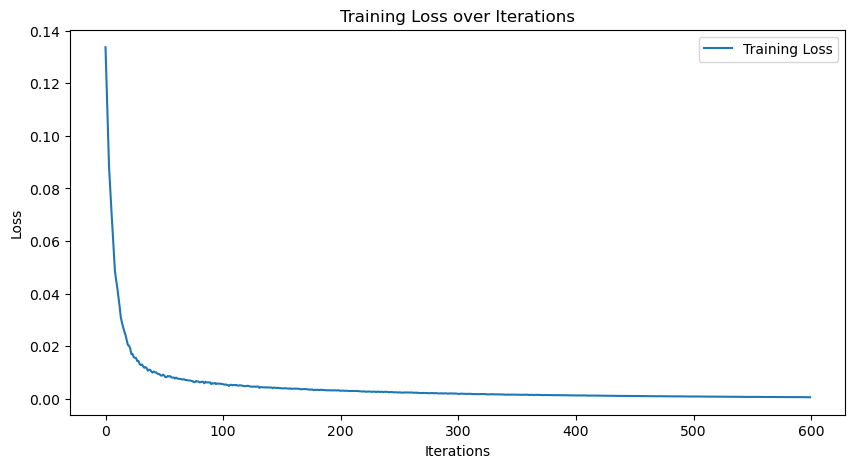

In [44]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(gbr_best.train_score_, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.show()